<a href="https://colab.research.google.com/github/EbnAbona/AI-For-Music-Not-Impossible/blob/Master/SeniorDesignCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, Dataset
import time
from fastprogress import master_bar, progress_bar
from torchvision.models import resnet18

In [12]:
class MyDataSet(Dataset):
  def __init__(self, X, y, scale_data=True):
    if not torch.is_tensor(X) and not torch.is_tensor(y):
      # Apply scaling if necessary
      self.X = torch.from_numpy(X).float()
      self.y = torch.from_numpy(y).float()
    
  def __len__(self):
    return len(self.X) - 40

  def __getitem__(self, i):
    return np.expand_dims(self.X[i: i+40,:], 0), self.y[i+40]

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, stride=1, bias=False)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.dropout1 = nn.Dropout(0.2)
        self.conv3 = nn.Conv2d(16, 32, 5)
        self.dropout2 = nn.Dropout(0.1)
        self.conv4 = nn.Conv2d(32, 64, 5)
        self.fc1 = nn.Linear(1549824, 40)
        self.fc2 = nn.Linear(40, 48)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        # x = F.max_pool2d(x, 2)
        x = self.relu(x)
        # x = self.dropout1(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.relu(x)
        # x = self.dropout2(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [11]:
def getSpectrograms():
  believer_X = np.load('/content/drive/MyDrive/Senior_Design/input & output npy\'s/believer_input.npy')
  interstellar_X = np.load('/content/drive/MyDrive/Senior_Design/input & output npy\'s/interstellar_input.npy')
  skrillex_X = np.load('/content/drive/MyDrive/Senior_Design/input & output npy\'s/skrillex_input.npy')
  dune_X = np.load('/content/drive/MyDrive/Senior_Design/input & output npy\'s/dune_input.npy')
  return believer_X, interstellar_X, skrillex_X, dune_X

In [ ]:
def plotData(data, original, title):
  plt.figure().clear()
  plt.close()
  plt.cla()
  plt.clf()
  plt.plot(data.cpu().detach().numpy(), label = "Predicted")
  plt.title(f'{title} - Predicted')
  plt.show()
  plt.plot(original.cpu().detach().numpy(), label = "Original")
  plt.title(f'{title} - Original')
  plt.show()

In [ ]:
def getSets(believer_X, interstellar_X, skrillex_X, dune_X):
  train_Y = np.load('/content/drive/MyDrive/Senior_Design/normalizedTraining_output.npy').T
  train_X = np.log10(np.abs(np.concatenate((believer_X, interstellar_X, skrillex_X), axis=1))+1e-15).T
  test_Y = np.load('/content/drive/MyDrive/Senior_Design/normalizedTesting_output.npy').T
  test_X = np.log10(np.abs(dune_X)+1e-15).T
  return train_X, train_Y, test_X, test_Y

In [ ]:
def buildDatasets(train_X, train_Y, test_X, test_Y):
  dataset_train = MyDataSet(train_X,train_Y)
  dataset_test = MyDataSet(test_X,test_Y)
  return dataset_train, dataset_test

In [ ]:
def saveCheckpoint(EPOCH, model_state_dict, optimizer_state_dict, LOSS):
  torch.save({
            'epoch': EPOCH,
            'model_state_dict': model_state_dict,
            'optimizer_state_dict': optimizer_state_dict,
            'loss': LOSS,
            }, '/content/drive/MyDrive/Senior_Design/latestCheckpoint.pt')

In [18]:
def trainModel(dataset_train, num_epochs=40, batch_size=40, loadCheckPoint=False, saveModel=True, saveCheckpoints=True, plotResults=True, pretrained=False):
  lr = 1e-4

  train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
  model= ConvNet().cuda()
  if pretrained==True:
    model = resnet18(pretrained=True).cuda()
    model.conv1=nn.Conv2d(1, model.conv1.out_channels, 
                          kernel_size=model.conv1.kernel_size[0], 
                          stride=model.conv1.stride[0], 
                          padding=model.conv1.padding[0]).cuda()
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 48).cuda()
  loss_function = nn.L1Loss().cuda()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)

  best_loss = 0.0
  last_loss = 0.0
  
  if loadCheckPoint == True:
    checkpoint = torch.load('/content/drive/MyDrive/Senior_Design/latestCheckpoint.pt')
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    last_loss = checkpoint['loss']

  # Run the training loop
  mb = master_bar(range(num_epochs))
  for epoch in mb:
    start_time = time.time()

    # Set current loss value
    current_loss = 0.0
    i = 0
    # Iterate over the DataLoader for training data
    for data in progress_bar(train_loader, parent=mb):
      # Get and prepare inputs
      inputs, targets = data
      inputs, targets = inputs.float(), targets.float()
      
      # Zero the gradients
      optimizer.zero_grad()
      
      # Perform forward pass
      outputs = model(inputs.cuda())
      
      # Compute loss
      loss = loss_function(outputs, targets.cuda())
      
      # Perform backward pass
      loss.backward()
      
      # Perform optimization
      optimizer.step()
      
      # Print statistics
      current_loss += loss.item()
      last_loss = current_loss
      if i % 100 == 0:
        elapsed = time.time() - start_time
        mb.write(f'Epoch {epoch+1} - Loss after mini-batch {(i + 1):5d}: {(current_loss / len(train_loader)):.8f} - Time: {elapsed:.0f}s')
        current_loss = 0.0
      i = i + 1
    if last_loss > best_loss and saveCheckpoints == True:
      saveCheckpoint(epoch, model.state_dict(), optimizer.state_dict(), last_loss)
      best_loss = last_loss

    if epoch % 5 == 0 and plotResults == True:
      plotData(outputs, targets, f"Epoch {epoch+1}")
  if saveModel == True:
    torch.save(model.state_dict(), '/content/drive/MyDrive/Senior_Design/finalTrainedModel.pt')
  return model

In [19]:
def predictModel(test_dataset):
  batch_size = 256
  test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)
  model= ConvNet()
  model.load_state_dict(torch.load('/content/drive/MyDrive/Senior_Design/finalTrainedModel.pt', map_location=torch.device('cpu')))

  all_outputs = []
  pb = progress_bar(test_loader)
  i = 0
  for data in pb:
    # Get and prepare inputs
    inputs, targets = data
    inputs, targets = inputs.float(), targets.float()
    
    # Perform forward pass
    outputs = model(inputs)
    if i == 0:
      all_outputs = outputs.detach().numpy()
    else:
      all_outputs = np.concatenate((all_outputs, outputs.detach().numpy()), axis=0)
    i+=1
  return all_outputs

In [20]:
believer_X, interstellar_X, skrillex_X, dune_X = getSpectrograms()

In [ ]:
train_X, train_Y, test_X, test_Y = getSets(believer_X, interstellar_X, skrillex_X, dune_X)

In [ ]:
dataset_train, dataset_test = buildDatasets(train_X, train_Y, test_X, test_Y)

2 Hours and 10 minutes of training on GPU

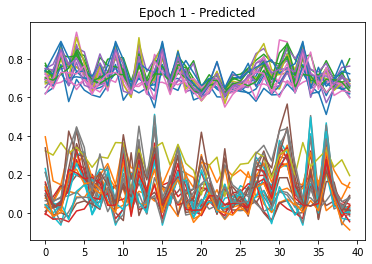

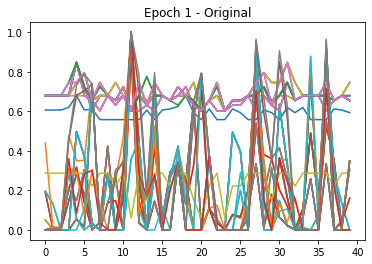

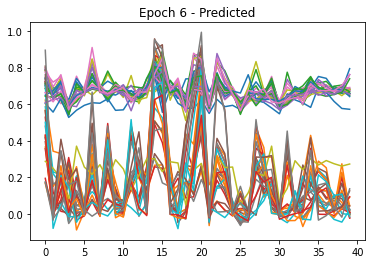

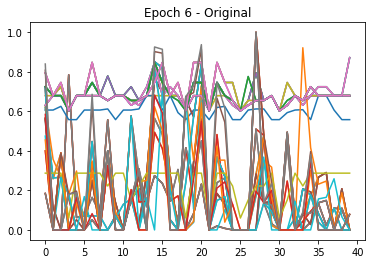

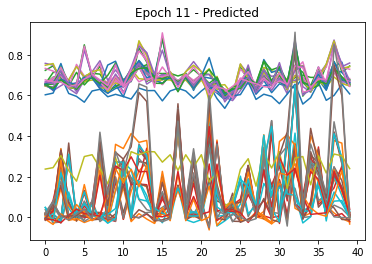

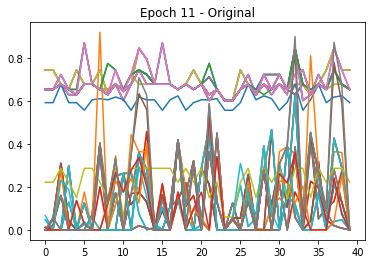

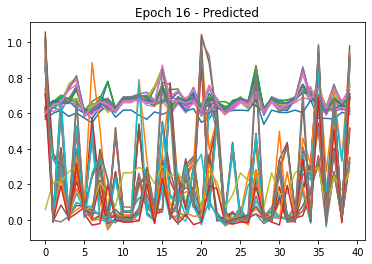

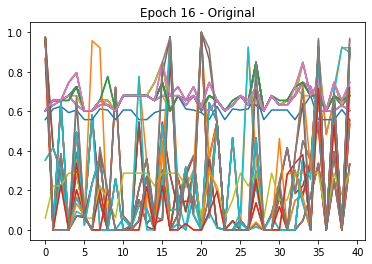

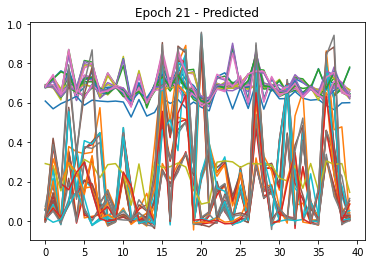

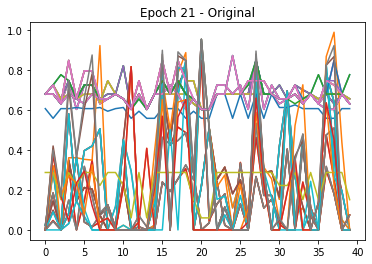

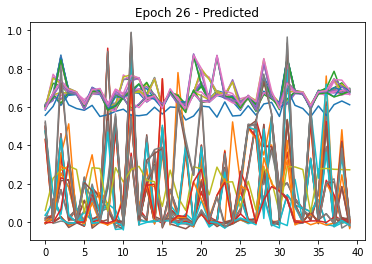

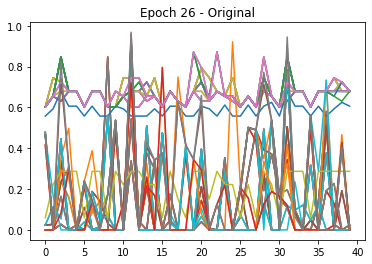

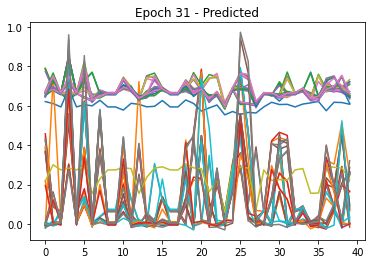

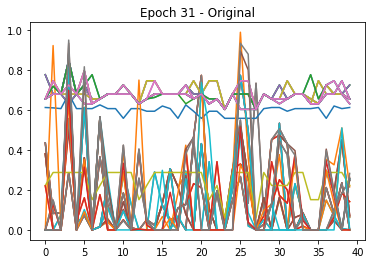

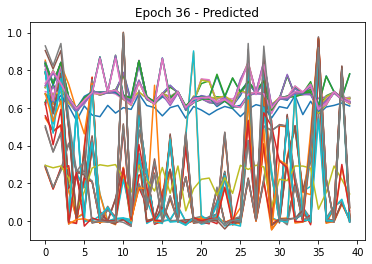

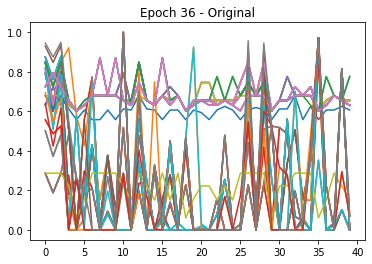

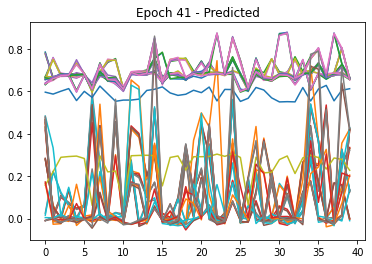

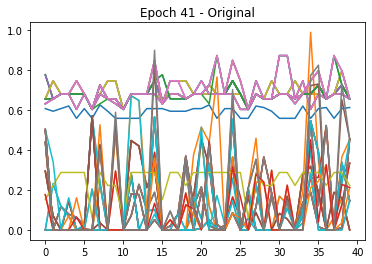

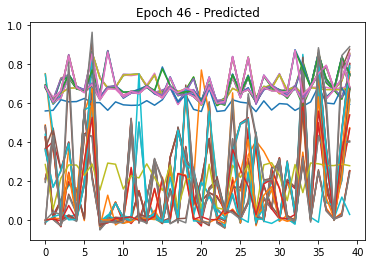

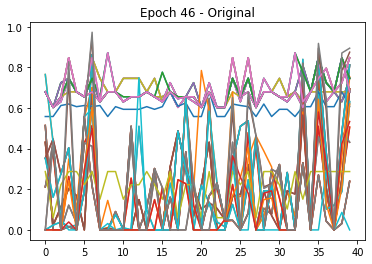

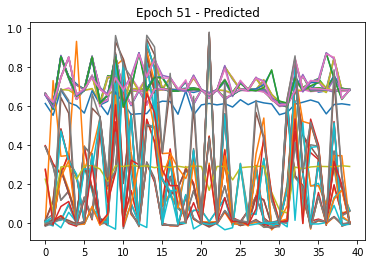

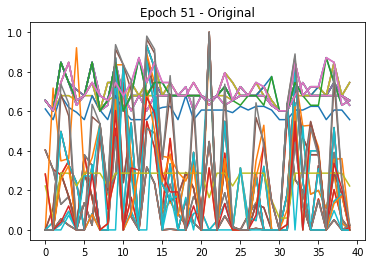

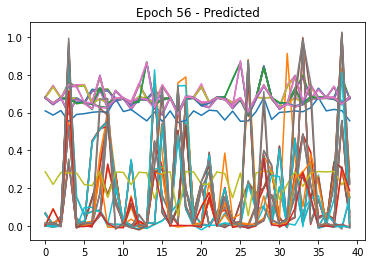

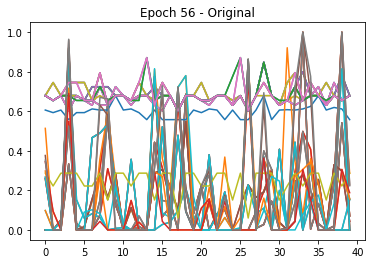

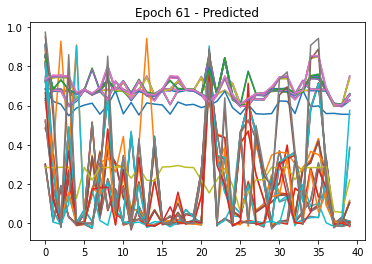

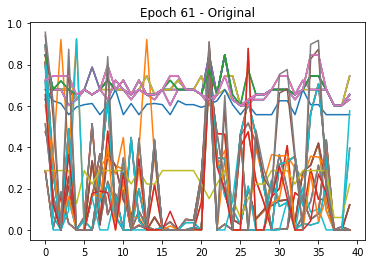

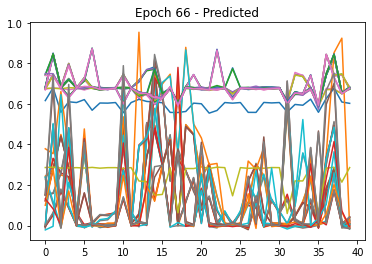

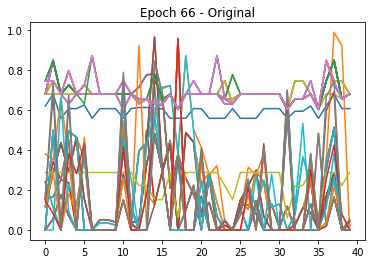

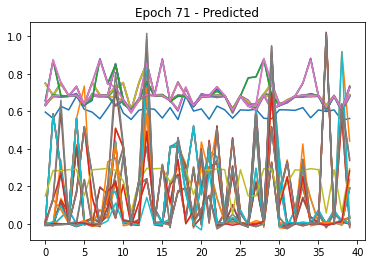

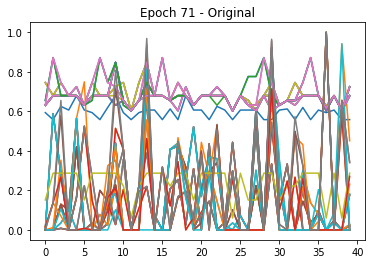

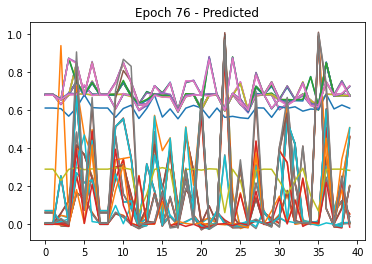

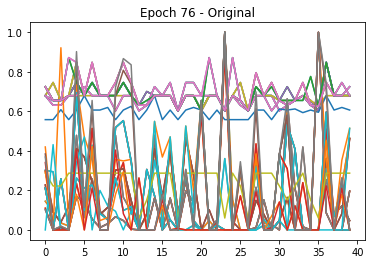

In [21]:
model = trainModel(dataset_train=dataset_train, 
                   num_epochs=80, 
                   batch_size=40, 
                   loadCheckPoint=False, 
                   saveModel=True, 
                   saveCheckpoints=True, 
                   plotResults=True, 
                   pretrained=False)

7 Minutes on predicting on CPU

In [22]:
prediction = predictModel(dataset_test)

In [24]:
prediction.shape

(7718, 48)

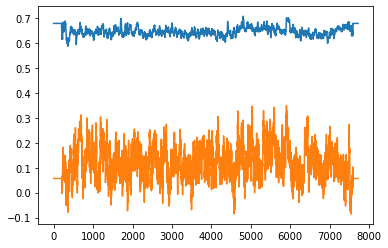

In [36]:
_ = plt.plot(prediction[:, :2])

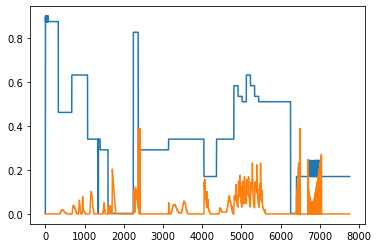

In [39]:
_ = plt.plot(test_Y[:, :2])

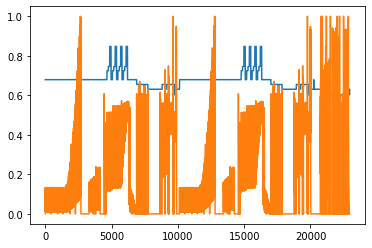

In [40]:
_ = plt.plot(train_Y[:, :2])